In [1]:
import pathlib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

BATCH_SIZE = 32
IMAGE_SIZE = (512, 512)

data_dir = str((pathlib.Path.cwd().parent /
                'data/train_image/regrouped').resolve())
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                                    validation_split=0.2,
                                                                    subset="training",
                                                                    seed=137,
                                                                    image_size=IMAGE_SIZE,
                                                                    batch_size=BATCH_SIZE)
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                                         validation_split=0.2,
                                                                         subset="validation",
                                                                         seed=137,
                                                                         image_size=IMAGE_SIZE,
                                                                         batch_size=BATCH_SIZE)

class_names = train_dataset.class_names
print(class_names)

Found 1164 files belonging to 3 classes.
Using 932 files for training.
Found 1164 files belonging to 3 classes.
Using 232 files for validation.
['0', '1', '2']


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from skimage import (exposure, measure, morphology, segmentation, color, filters)

%matplotlib inline

def segment_from_image(
    image_array: np.ndarray, erosion=2, closing=4, dilation=16
):
    """
    Segment critical parts from image array
    :param image_array: Image in numpy array form
    :param erosion: erosion connectivity factor
    :param closing: closing connectivity factor
    :param dilation: dilation connectivity factor
    :return: transformed image array
    """
    # Assert that image is of stipulated shape
    try:
        assert len(image_array.shape) == 3 and image_array.shape[2] == 3
    except AssertionError:
        logger.error("Image array must be of shape (?, ?, 3)")

    # Type casting as int and create binary mask using mean value
    image_array = image_array.astype("uint8")
    image_array = exposure.equalize_hist(image_array)
    image_array_binary_mask = image_array < image_array.mean()

    # Clear binary mask boarder
    for channel in range(image_array_binary_mask.shape[2]):
        image_array_binary_mask[:, :, channel] = segmentation.clear_border(
            image_array_binary_mask[:, :, channel]
        )

    # Label the image and dim the binary mask according to labelled region
    labelled_image = measure.label(image_array_binary_mask)
    regions = measure.regionprops(labelled_image)
    areas = [(region.area, region.label) for region in regions]
    areas.sort(key=lambda x: x[0])

    if len(areas) > 2:
        max_area = areas[-5][0]
        for region in regions:
            if region.area < max_area:
                for channel in region.coords:
                    image_array_binary_mask[
                        channel[0], channel[1], channel[2]
                    ] = 0

    # Additional CV steps to further segment core areas from the rest of the image
    image_array_binary_mask = morphology.binary_erosion(
        image_array_binary_mask, selem=np.ones((erosion,) * 3)
    )
    image_array_binary_mask = morphology.binary_closing(
        image_array_binary_mask, selem=np.ones((closing,) * 3)
    )
    image_array_binary_mask = morphology.binary_dilation(
        image_array_binary_mask, selem=np.ones((dilation,) * 3)
    )

    return np.multiply(image_array_binary_mask, image_array)

# https://www.kaggle.com/ankasor/improved-lung-segmentation-using-watershed

def generate_markers(image):
    #Creation of the internal Marker
    marker_internal = image < image.mean()
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((512, 512), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

def seperate_lungs(image):
    #Creation of the markers as shown above:
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    #Watershed algorithm
    watershed = morphology.watershed(sobel_gradient, marker_watershed)
    
    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    #Use the internal marker and the Outline that was just created to generate the lungfilter
    lungfilter = np.bitwise_or(marker_internal, outline)
    #Close holes in the lungfilter
    #fill_holes is not used here, since in some slices the heart would be reincluded by accident
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
    
    #Apply the lungfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(lungfilter == 1, image, 0*np.ones((512, 512)))
    
    return segmented, lungfilter, outline, watershed, sobel_gradient, marker_internal, marker_external, marker_watershed

/Users/luter/Repository/cs-medical-image-classifier/.venv/lib/python3.8/site-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/Users/luter/Repository/cs-medical-image-classifier/.venv/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/Users/luter/Repository/cs-medical-image-classifier/.venv/lib/python3.8/site-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/Users/luter/

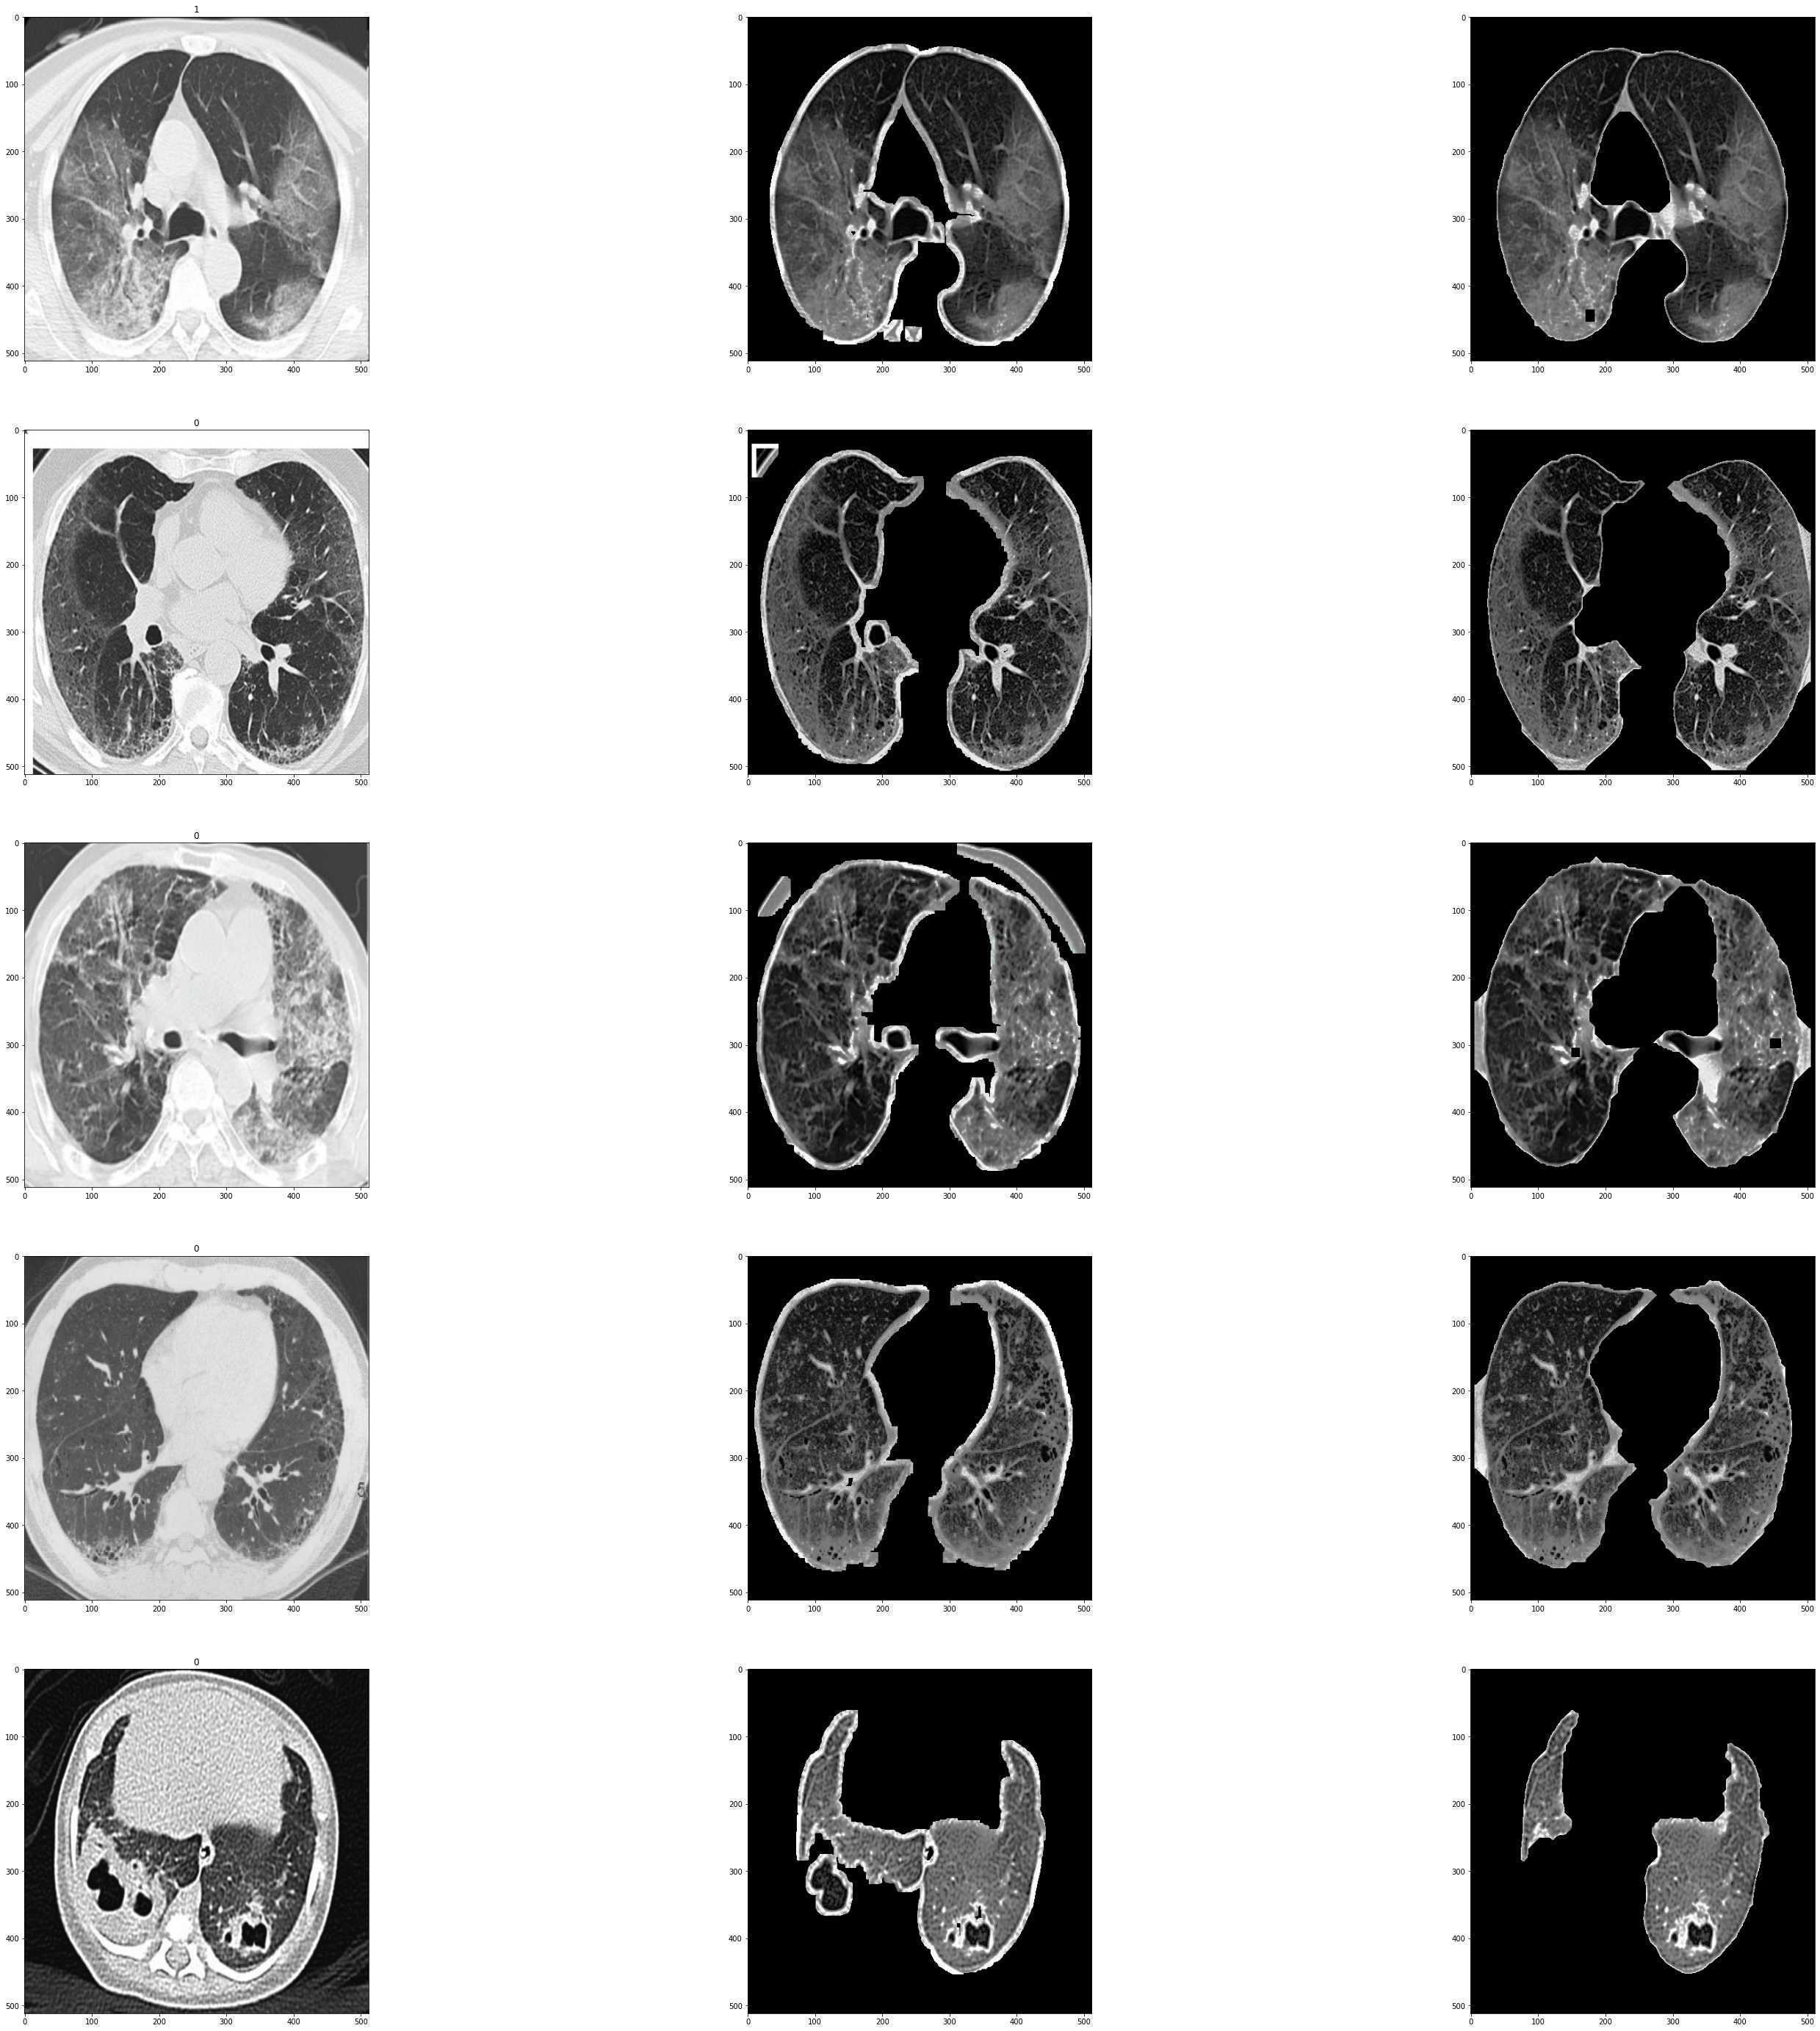

In [3]:
show_examples = 5
fig, ax = plt.subplots(show_examples, 3, figsize=(
    show_examples * 10, show_examples * 10))
images = [image.numpy() for images in train_dataset.take(1) for image in images]

for index in range(show_examples):
    example = images[0][index].astype('uint8')
    ax[index][0].set_title(images[1][index])
    ax[index][0].imshow(example)
    ax[index][1].imshow(segment_from_image(example)) # Naive
    ax[index][2].imshow(seperate_lungs(color.rgb2gray(exposure.equalize_hist(example)))[0], cmap='gray') # Watershed

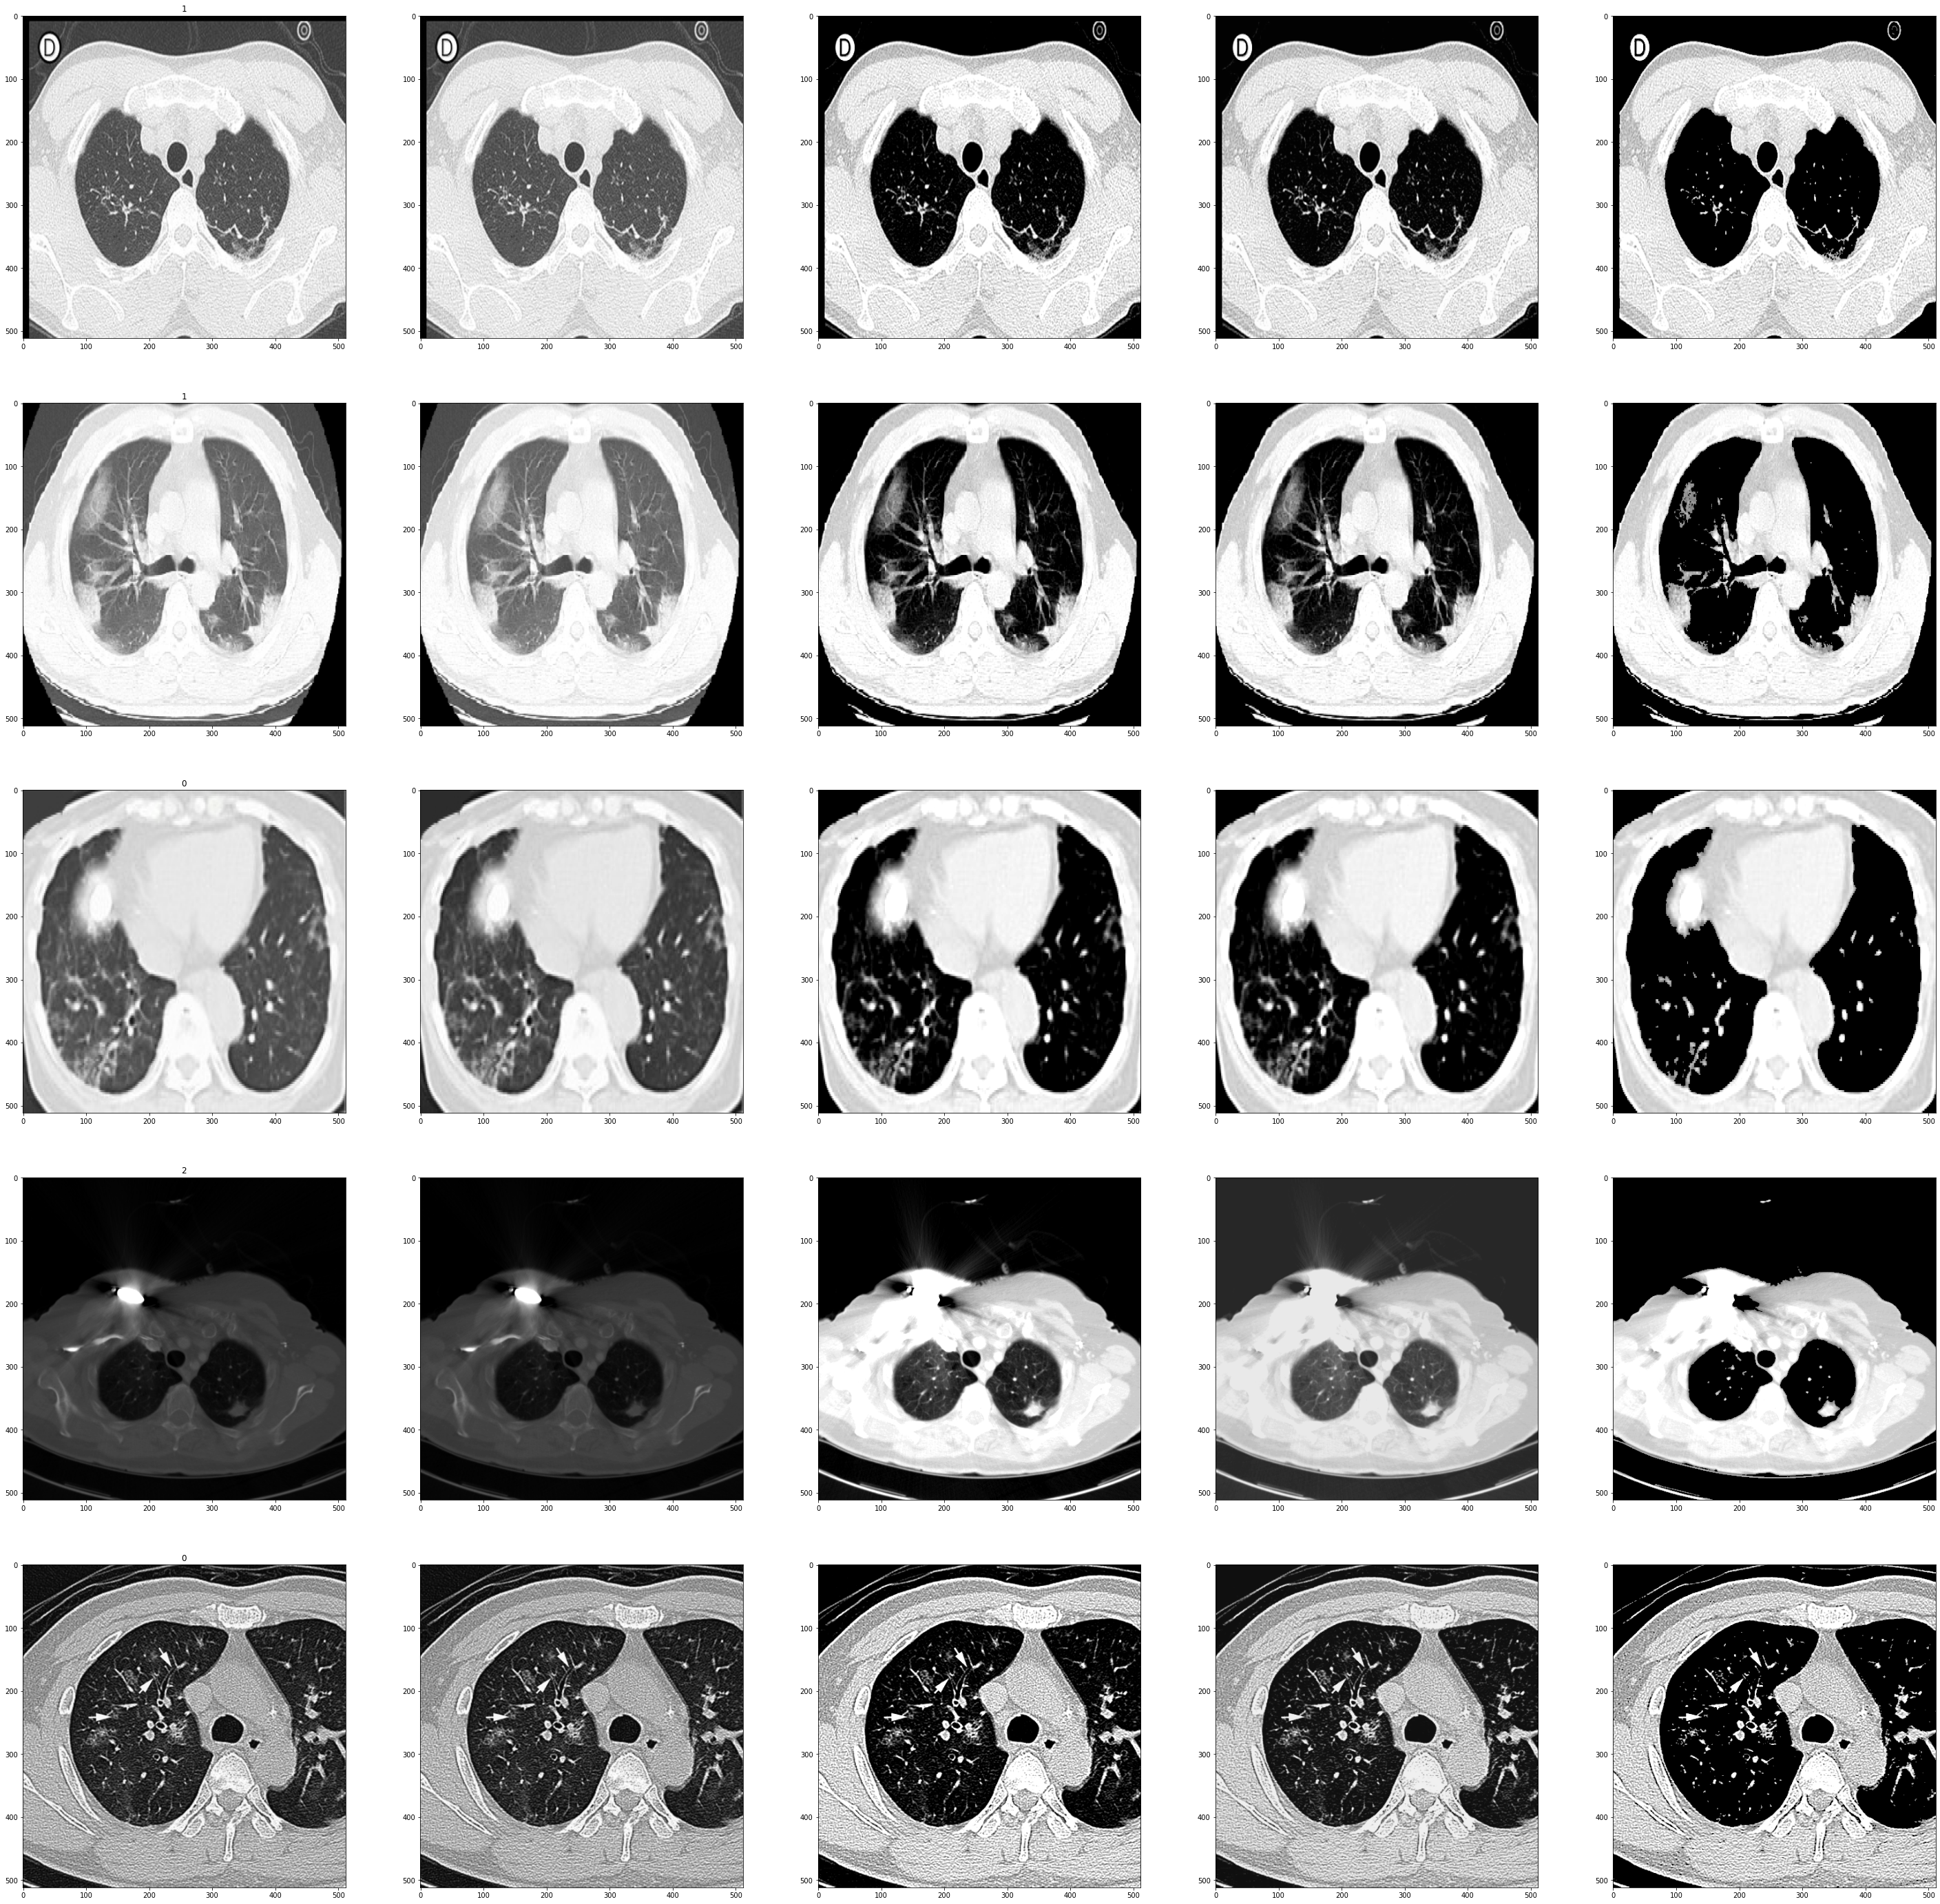

In [4]:
from skimage.exposure import rescale_intensity, equalize_adapthist, equalize_hist
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
from skimage.restoration import denoise_wavelet

images, labels = [image.numpy() for images in train_dataset.take(1) for image in images]
show_examples = 5
fig, ax = plt.subplots(show_examples, 5, figsize=(show_examples * 10, show_examples * 10))

for index in range(show_examples):
    random_idx = np.random.randint(0, images.shape[0])
    image = images[random_idx]
    label = labels[random_idx]

    example = image.astype('uint8')
    grayscale = rgb2gray(example)
    lower, upper = np.percentile(grayscale, (25, 90))
    rescaled = rescale_intensity(grayscale, in_range=(lower, upper))
    denoised = denoise_wavelet(rescaled, method='BayesShrink', mode='soft', rescale_sigma=True)
    binary = denoised > threshold_otsu(denoised)
    final = binary * rescaled
    
    ax[index][0].set_title(label)
    ax[index][0].imshow(example)
    ax[index][1].imshow(grayscale, cmap='gray')
    ax[index][2].imshow(rescaled, cmap='gray')
    ax[index][3].imshow(denoised, cmap='gray')
    ax[index][4].imshow(final, cmap='gray')    